# Speech to Text with OpenVINO™

This tutorial demonstrates speech-to-text recognition with OpenVINO.

This tutorial uses the [quartznet 15x5](https://docs.openvino.ai/2021.4/omz_models_model_quartznet_15x5_en.html) model. QuartzNet performs automatic speech recognition. Its design is based on the Jasper architecture, which is a convolutional model trained with Connectionist Temporal Classification (CTC) loss. The model is available from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/).


## Imports

In [ ]:
!pip install -q "librosa>=0.8.1"

In [1]:
from pathlib import Path
import sys

import torch
import torch.nn as nn
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import scipy
from openvino.runtime import Core, serialize, Tensor
from openvino.tools import mo

## Settings

In this part, all variables used in the notebook are set.

In [2]:
model_folder = "model"
download_folder = "output"
data_folder = "../data"

precision = "FP16"
model_name = "quartznet-15x5-en"

## Download and Convert Public Model
If it is your first run, models will be downloaded and converted here. It my take a few minutes. Use `omz_downloader` and `omz_converter`, which are command-line tools from the `openvino-dev` package. 


### Download Model

The `omz_downloader` tool automatically creates a directory structure and downloads the selected model. This step is skipped if the model is already downloaded. The selected model comes from the public directory, which means it must be converted into OpenVINO Intermediate Representation (OpenVINO IR).

In [3]:
# Check if a model is already downloaded (to the download directory).
path_to_model_weights = Path(f'{download_folder}/public/{model_name}/models')
downloaded_model_file = list(path_to_model_weights.glob('*.pth'))

if not path_to_model_weights.is_dir() or len(downloaded_model_file) == 0:
    download_command = f"omz_downloader --name {model_name} --output_dir {download_folder} --precision {precision}"
    ! $download_command

### Convert Model

In previous step, model was downloaded in PyTorch format. Currently, PyTorch models supported in OpenVINO via ONNX exporting, `torch.onnx.export` function helps to trace PyTorch model to ONNX and save it on disk. It is also recommended to convert model to OpenVINO Intermediate Representation format for applying optimizations.

In [4]:
def convert_model(model_path:Path, converted_model_path:Path):
    """
    helper function for converting QuartzNet model to IR
    The function accepts path to directory with dowloaded packages, weights and configs using OMZ downloader, 
    initialize model, export it to ONNX and then convert to OpenVINO model and serialize it to IR.
    Params:
      model_path: path to model modules, weights and configs downloaded via omz_downloader
      converted_model_path: path for saving converted model
    Returns:
      None
    """
    # add model path to PYTHONPATH for access to downloaded modules
    sys.path.append(str(model_path))
    
    # import necessary classes
    from ruamel.yaml import YAML

    from nemo.collections.asr import JasperEncoder, JasperDecoderForCTC
    from nemo.core import NeuralModuleFactory, DeviceType

    YAML = YAML(typ='safe')

    # utility fornction fr replacing 1d convolutions to 2d for better efficiency
    def convert_to_2d(model):
        for name, l in model.named_children():
            layer_type = l.__class__.__name__
            if layer_type == 'Conv1d':
                new_layer = nn.Conv2d(l.in_channels, l.out_channels,
                                      (1, l.kernel_size[0]), (1, l.stride[0]),
                                      (0, l.padding[0]), (1, l.dilation[0]),
                                      l.groups, False if l.bias is None else True, l.padding_mode)
                params = l.state_dict()
                params['weight'] = params['weight'].unsqueeze(2)
                new_layer.load_state_dict(params)
                setattr(model, name, new_layer)
            elif layer_type == 'BatchNorm1d':
                new_layer = nn.BatchNorm2d(l.num_features, l.eps)
                new_layer.load_state_dict(l.state_dict())
                new_layer.eval()
                setattr(model, name, new_layer)
            else:
                convert_to_2d(l)
    
    # model class
    class QuartzNet(torch.nn.Module):
        def __init__(self, model_config, encoder_weights, decoder_weights):
            super().__init__()
            with open(model_config, 'r') as config:
                model_args = YAML.load(config)
            _ = NeuralModuleFactory(placement=DeviceType.CPU)

            encoder_params = model_args['init_params']['encoder_params']['init_params']
            self.encoder = JasperEncoder(**encoder_params)
            self.encoder.load_state_dict(torch.load(encoder_weights, map_location='cpu'))

            decoder_params = model_args['init_params']['decoder_params']['init_params']
            self.decoder = JasperDecoderForCTC(**decoder_params)
            self.decoder.load_state_dict(torch.load(decoder_weights, map_location='cpu'))

            self.encoder._prepare_for_deployment()
            self.decoder._prepare_for_deployment()
            convert_to_2d(self.encoder)
            convert_to_2d(self.decoder)

        def forward(self, input_signal):
            input_signal = input_signal.unsqueeze(axis=2)
            i_encoded = self.encoder(input_signal)
            i_log_probs = self.decoder(i_encoded)

            shape = i_log_probs.shape
            return i_log_probs.reshape(shape[0], shape[1], shape[3])
    
    # path to configs and weights for creating model instane
    model_config = model_path / ".nemo_tmp/module.yaml"
    encoder_weights = model_path / ".nemo_tmp/JasperEncoder.pt"
    decoder_weights = model_path / ".nemo_tmp/JasperDecoderForCTC.pt"
    # create model instance
    model = QuartzNet(model_config, encoder_weights, decoder_weights)
    # turn model to inference mode
    model.eval()
    # export model to ONNX with preserving dynamic shapes
    onnx_model_path = model_path / "quartznet.onnx"
    torch.onnx.export(
        model, 
        torch.zeros([1, 64, 128]), 
        onnx_model_path, 
        opset_version=11, 
        input_names=["audio_signal"], 
        output_names=['output'], 
        dynamic_axes={"audio_signal": {0: "batch_size", 2: "wave_len"}, "output": {0: "batch_size", 2: "wave_len"}}
    )
    # convert model to OpenVINO Model using OpenVINO Model Optimizer
    ov_model = mo.convert_model(str(onnx_model_path))
    # serialize model to IR for next usage
    serialize(ov_model, str(converted_model_path))

In [5]:
# Check if a model is already converted (in the model directory).
path_to_converted_weights = Path(f'{model_folder}/public/{model_name}/{precision}/{model_name}.bin')
path_to_converted_model = Path(f'{model_folder}/public/{model_name}/{precision}/{model_name}.xml')

if not path_to_converted_weights.is_file():
    downloaded_model_path = Path("output/public/quartznet-15x5-en/models")
    convert_model(downloaded_model_path, path_to_converted_model)

## Audio Processing

Now that the model is converted, load an audio file. 

### Define constants

First, locate an audio file and define the alphabet used by the model. This tutorial uses the Latin alphabet beginning with a space symbol and ending with a blank symbol. In this case it will be `~`, but that could be any other character.

In [6]:
audio_file_name = "edge_to_cloud.ogg"
alphabet = " abcdefghijklmnopqrstuvwxyz'~"

### Available Audio Formats

There are multiple supported audio formats that can be used with the model: 

AIFF, AU, AVR, CAF, FLAC, HTK, SVX, MAT4, MAT5, MPC2K, OGG, PAF, PVF, RAW, RF64, SD2, SDS, IRCAM, VOC, W64, WAV, NIST, WAVEX, WVE, XI

### Load Audio File

Load the file after checking a file extension. Pass `sr` (stands for a `sampling rate`) as an additional parameter. The model supports files with a `sampling rate` of 16 kHz.

In [7]:
audio, sampling_rate = librosa.load(path=f'{data_folder}/audio/{audio_file_name}', sr=16000)

Now, you can play your audio file.

In [8]:
ipd.Audio(audio, rate=sampling_rate)

### Visualise Audio File

You can visualize how your audio file presents on a wave plot and spectrogram.

/tmp/ipykernel_3057245/2518307745.py:2: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sampling_rate, max_points=50000, x_axis='time', offset=0.0);


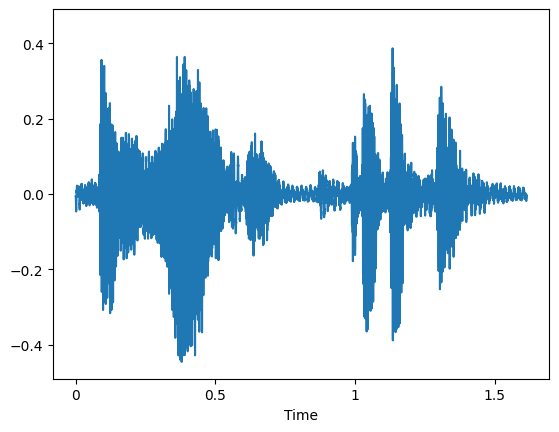

(1025, 51)


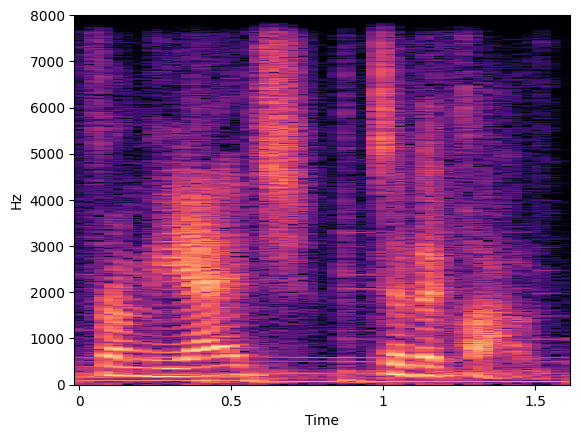

In [9]:
plt.figure()
librosa.display.waveshow(y=audio, sr=sampling_rate, max_points=50000, x_axis='time', offset=0.0);
plt.show()
specto_audio = librosa.stft(audio)
specto_audio = librosa.amplitude_to_db(np.abs(specto_audio), ref=np.max)
print(specto_audio.shape)
librosa.display.specshow(specto_audio, sr=sampling_rate, x_axis='time', y_axis='hz');

### Change Type of Data

The file loaded in the previous step may contain data in `float` type with a range of values between -1 and 1. To generate a viable input, multiply each value by the max value of `int16` and convert it to `int16` type. 

In [10]:
if max(np.abs(audio)) <= 1:
    audio = (audio * (2**15 - 1))
audio = audio.astype(np.int16)

### Convert Audio to Mel Spectrum

Next, convert the pre-pre-processed audio to [Mel Spectrum](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53). For more information on why it needs to be done, refer to [this article](https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505).

In [11]:
def audio_to_mel(audio, sampling_rate):
    assert sampling_rate == 16000, "Only 16 KHz audio supported"
    preemph = 0.97
    preemphased = np.concatenate([audio[:1], audio[1:] - preemph * audio[:-1].astype(np.float32)])

    # Calculate the window length.
    win_length = round(sampling_rate * 0.02)

    # Based on the previously calculated window length, run short-time Fourier transform.
    spec = np.abs(librosa.core.spectrum.stft(preemphased, n_fft=512, hop_length=round(sampling_rate * 0.01),
                  win_length=win_length, center=True, window=scipy.signal.windows.hann(win_length), pad_mode='reflect'))

    # Create mel filter-bank, produce transformation matrix to project current values onto Mel-frequency bins.
    mel_basis = librosa.filters.mel(sr=sampling_rate, n_fft=512, n_mels=64, fmin=0.0, fmax=8000.0, htk=False)
    return mel_basis, spec


def mel_to_input(mel_basis, spec, padding=16):
    # Convert to a logarithmic scale.
    log_melspectrum = np.log(np.dot(mel_basis, np.power(spec, 2)) + 2 ** -24)

    # Normalize the output.
    normalized = (log_melspectrum - log_melspectrum.mean(1)[:, None]) / (log_melspectrum.std(1)[:, None] + 1e-5)

    # Calculate padding.
    remainder = normalized.shape[1] % padding
    if remainder != 0:
        return np.pad(normalized, ((0, 0), (0, padding - remainder)))[None]
    return normalized[None]

### Run Conversion from Audio to Mel Format

In this step, convert a current audio file into [Mel scale](https://en.wikipedia.org/wiki/Mel_scale).

In [12]:
mel_basis, spec = audio_to_mel(audio=audio.flatten(), sampling_rate=sampling_rate)

### Visualise Mel Spectogram

For more information about Mel spectrogram, refer to this [article](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0). The first image visualizes Mel frequency spectrogram, the second one presents filter bank for converting Hz to Mels.

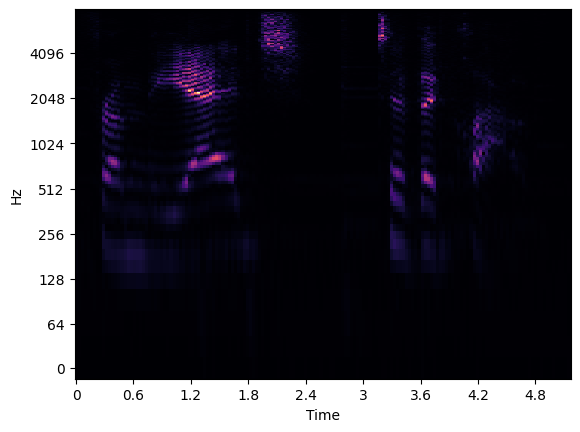

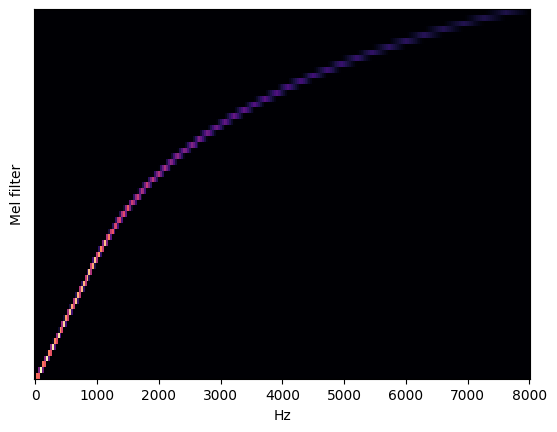

In [13]:
librosa.display.specshow(data=spec, sr=sampling_rate, x_axis='time', y_axis='log');
plt.show();
librosa.display.specshow(data=mel_basis, sr=sampling_rate, x_axis='linear');
plt.ylabel('Mel filter');

### Adjust Mel scale to Input

Before reading the network, make sure that the input is ready.

In [14]:
audio = mel_to_input(mel_basis=mel_basis, spec=spec)

## Load the Model

Now, you can read and load the network. 

In [15]:
ie = Core()

You may run the network on multiple devices. By default, it will load the model on CPU (you can choose manually CPU, GPU, MYRIAD, etc.) or let the engine choose the best available device (AUTO).

To list all available devices that can be used, run `print(ie.available_devices)` command.

In [16]:
print(ie.available_devices)

['CPU', 'GPU']


To change the device used for your network, change value of `device_name` variable to one of the values listed by `print()` in the cell above.

In [17]:
model = ie.read_model(
    model=f"{model_folder}/public/{model_name}/{precision}/{model_name}.xml"
)
model_input_layer = model.input(0)
shape = model_input_layer.partial_shape
shape[2] = -1
model.reshape({model_input_layer: shape})
compiled_model = ie.compile_model(model=model, device_name="CPU")

### Do Inference

Everything is set up. Now, the only thing that remains is passing input to the previously loaded network and running inference.

In [18]:
output_layer_ir = compiled_model.output(0)

character_probabilities = compiled_model([Tensor(audio)])[output_layer_ir]

### Read Output

After inference, you need to reach out the output. The default output format for `quartznet 15x5` are per-frame probabilities (after LogSoftmax) for every symbol in the alphabet, name - output, shape - 1x64x29, output data format is BxNxC, where:

* B - batch size
* N - number of audio frames
* C - alphabet size, including the Connectionist Temporal Classification (CTC) blank symbol

You need to make it in a more human-readable format. To do this you, use a symbol with the highest probability. When you hold a list of indexes that are predicted to have the highest probability, due to limitations given by [Connectionist Temporal Classification Decoding](https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7) you will remove concurrent symbols and then remove all the blanks.

The last step is getting symbols from corresponding indexes in charlist.

In [19]:
# Remove unnececery dimension
character_probabilities = np.squeeze(character_probabilities)

# Run argmax to pick most possible symbols
character_probabilities = np.argmax(character_probabilities, axis=1)

### Implementation of Decoding

To decode previously explained output, you need the [Connectionist Temporal Classification (CTC) decode](https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7) function. This solution will remove consecutive letters from the output.

In [20]:
def ctc_greedy_decode(predictions):
    previous_letter_id = blank_id = len(alphabet) - 1
    transcription = list()
    for letter_index in predictions:
        if previous_letter_id != letter_index != blank_id:
            transcription.append(alphabet[letter_index])
        previous_letter_id = letter_index
    return ''.join(transcription)

### Run Decoding and Print Output

In [21]:
transcription = ctc_greedy_decode(character_probabilities)
print(transcription)

from the edge to the cloud
